In [1]:
import pandas as pd

# Reading cleaned dataset file

In [2]:
df = pd.read_csv('./kdd-cleaned.csv')

# DELIVERABLE TWO STARTS FROM HERE

- Apply at-least 3 Machine Learning algorithms.
- Compare results of all models.
- How results helped in addressing the problem?

In [3]:
df.head()

,duration,protocol_type,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,...,rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,class
0,0.0,tcp,SF,491.0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,1.00,0.00,0.0,150.0,25.0,0.03,0.00,0.00,normal
1,0.0,udp,SF,146.0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.08,0.15,0.0,255.0,1.0,0.02,0.00,0.00,normal
2,0.0,tcp,S0,0.0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,0.05,0.07,0.0,255.0,26.0,0.05,0.00,0.00,anomaly
3,0.0,tcp,SF,232.0,0.0,0,0.0,0.0,0.0,0.0,...,0.0,1.00,0.00,0.0,30.0,255.0,0.00,0.03,0.04,normal
4,0.0,tcp,SF,199.0,420.0,0,0.0,0.0,0.0,0.0,...,0.0,1.00,0.00,0.0,255.0,255.0,0.00,0.00,0.00,normal


# Some Features Analysis

In [4]:
# Checking relationship of flag categories with class label

class_counts = df.groupby(['flag', 'class']).size().reset_index(name='count')
class_pivot = class_counts.pivot(index='flag', columns='class', values='count').fillna(0)

class_pivot = class_pivot.reset_index()

class_pivot.columns.name = None
class_pivot.rename(columns={class_pivot.columns[1]: 'Class_0_Count-Normal',
                            class_pivot.columns[2]: 'Class_1_Count-Suspicious'}, inplace=True)

class_pivot['Total_Count'] = class_pivot['Class_0_Count-Normal'] + class_pivot['Class_1_Count-Suspicious']
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns

print(class_pivot)

   flag  Class_0_Count-Normal  Class_1_Count-Suspicious  Total_Count
0   OTH                  33.0                       7.0         40.0
1   REJ                7748.0                    2504.0      10252.0
2  RSTO                1266.0                     142.0       1408.0
3  RSTR                 816.0                       3.0        819.0
4    S0               34470.0                     329.0      34799.0
5    S1                   2.0                     317.0        319.0
6    S2                   2.0                      44.0         46.0
7    S3                   0.0                      29.0         29.0
8    SF                8809.0                   55066.0      63875.0
9    SH                 269.0                       0.0        269.0


# Feature Mapping (cat to num)

 - flag
 - protocol_type

In [5]:
pmap = {'icmp':0, 'tcp':1, 'udp':2}
df['protocol_type'] = df['protocol_type'].map(pmap)

fmap = {'SF':0, 'S0':1, 'REJ':2, 'RSTR':3, 'RSTO':4, 'SH':5, 'S1':6, 'S2':7, 'RSTOS0':8, 'S3':9, 'OTH':10}
df['flag'] = df['flag'].map(fmap)

# X/y split

In [6]:
X = df.drop(columns=['class'])
y = df['class']

### Imports For data split and feature scaling

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [8]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

### Train-Test Split = 70/30

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (78299, 32)
Test set size: (33557, 32)


# Import for models and metrices

In [10]:
# METRICES and FOLDS
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

# VISUALIZATION
import matplotlib.pyplot as plt

# MODELS
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# OTHERS
import time
import numpy as np

> common variables and structures for help in code + kfold cross validator initialization

In [11]:
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision_weighted',
    'recall': 'recall_weighted',
    'f1': 'f1_weighted'
}
# training time for all models
TRAINING_TIME = {}
# StratifiedKFold for consistent cross-validation
# 5 folds
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Understanding `compute_train_metrics` and `compute_test_metrics`

## Training Metrics (`compute_train_metrics`)
- Uses `cross_validate`, which splits the data, trains, and validates the model internally across k-folds.
- No need to call `model.fit` explicitly, as `cross_validate` handles it automatically.

## Test Metrics (`compute_test_metrics`)
- Requires the model to be explicitly trained using `model.fit`.
- Evaluates the trained model on the test set using metrics like accuracy, precision, recall, and F1 score.

## Key Workflow
1. **Training Metrics**: Computed via cross-validation (no manual fitting required).
2. **Test Metrics**: Computed after fitting the model on the entire training set.

These functions are used in each model evaluation

In [12]:
"""
Below function calculates values of different train metrices for
certain model after apply k-fold cross validation
"""
def compute_train_metrics(model, X_train, y_train):
    scores = cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
    mean_train_scores = {metric: np.mean(scores[f'test_{metric}']) for metric in scoring}
    return mean_train_scores

"""
Below function calculates values of different test metrices for
certain model and plots its confusion matrix
"""
def compute_test_metrics_and_plot_cm(model, X_test, y_test, model_name):
    y_test_pred = model.predict(X_test)
    test_metrics = {
        'accuracy': accuracy_score(y_test, y_test_pred),
        'precision': precision_score(y_test, y_test_pred, average='weighted'),
        'recall': recall_score(y_test, y_test_pred, average='weighted'),
        'f1': f1_score(y_test, y_test_pred, average='weighted')
    }
    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='Blues', colorbar=True)
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()
    return test_metrics

### Function: `plot_metrics`

This function creates a bar chart to compare training and testing metrics for any model.

#### What it Does:
- Takes training and testing metrics as input.
- Plots bars for each metric (e.g., accuracy, precision).
- Labels each bar with its exact value for clarity.
- Customizes colors and layout for easy understanding.

#### Output:
- A clear chart showing how the model performed on both training and testing data.

#### Example Use:
```python
plot_metrics(train_metrics, test_metrics, "Gaussian NB")


In [13]:
"""
Below function plots train and test metrics for different models,
it is a common function that will be used for all models
"""
def plot_metrics(train_metrics, test_metrics, model_name):
    metrics = list(train_metrics.keys())
    train_values = list(train_metrics.values())
    test_values = [test_metrics[metric] for metric in metrics]

    x = np.arange(len(metrics))  # Label locations
    width = 0.45  # Bar width

    fig, ax = plt.subplots()
    train_bars = ax.bar(x - width / 2, train_values, width, label='Train', color='skyblue')
    test_bars = ax.bar(x + width / 2, test_values, width, label='Test', color='orange')

    for bar in train_bars:
        height = bar.get_height()
        ax.annotate(f'{height:.5f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

    for bar in test_bars:
        height = bar.get_height()
        ax.annotate(f'{height:.5f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Scores')
    ax.set_title(f'{model_name} Train vs Test Metrics')
    ax.set_xticks(x)
    ax.set_xticklabels([metric.capitalize() for metric in metrics])
    ax.legend()

    plt.ylim(0, 1.3)
    plt.tight_layout()
    plt.show()

# FUNCTION TO PLOT ROC_CURVE

In [14]:
def plot_roc_curve(model, X_test, y_test, model_name):
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_scores = model.decision_function(X_test)
    else:
        raise ValueError(f"{model_name} does not support probability or decision score predictions.")

    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance Line')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.tight_layout()
    plt.show()

# MODEL TRAINING

> Models used:
- **Gaussian Naive Bayes (GNB):** A simple model that predicts by assuming all features are independent of each other.
- **Decision Tree (DT):** A model that splits data into branches to make decisions based on features.
- **Random Forest (RF):** A collection of many decision trees that work together to improve accuracy.
- **Support Vector Machine (SVM):** A method that draws the best line or boundary to separate different classes.
- **Logistic Regression (LR):** A model that predicts categories using a straight line and probability.
- **Gradient Boosting Classifier (GBC):** A technique that builds models one by one, each trying to fix the mistakes of the previous one.


# LOGISTIC REGRESSION

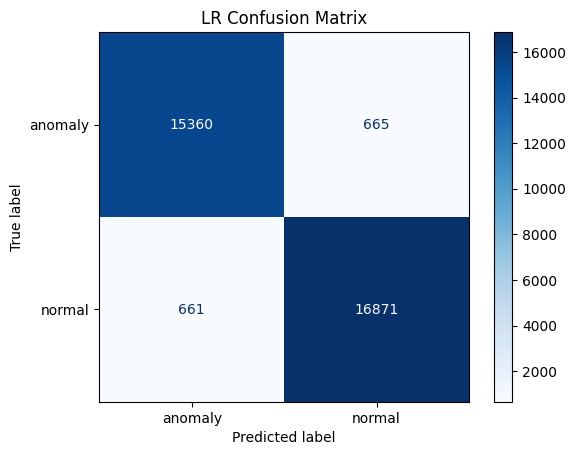

In [15]:
lr = LogisticRegression(random_state=42, max_iter=1000)

start_time = time.time()
train_metrics = compute_train_metrics(lr, X_train, y_train)
TRAINING_TIME['Logistic Regression'] = time.time() - start_time

lr.fit(X_train, y_train)
test_metrics = compute_test_metrics_and_plot_cm(lr, X_test, y_test,"LR")

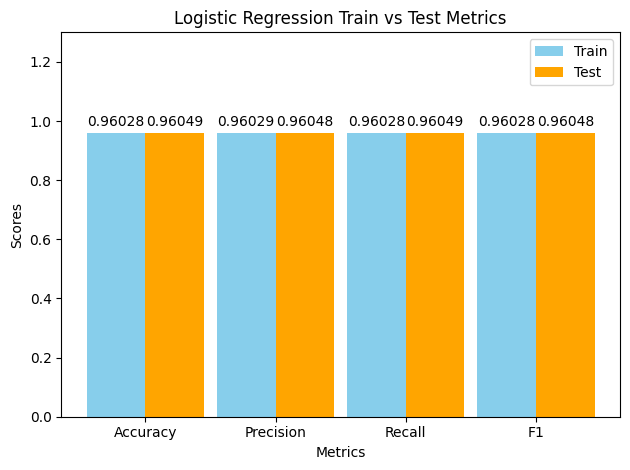

In [16]:
plot_metrics(train_metrics, test_metrics, "Logistic Regression")

In [17]:
plot_roc_curve(lr, X_test, y_test, "Logistic Regression")

ValueError: y_true takes value in {'anomaly', 'normal'} and pos_label is not specified: either make y_true take value in {0, 1} or {-1, 1} or pass pos_label explicitly.

# DECISION TREES

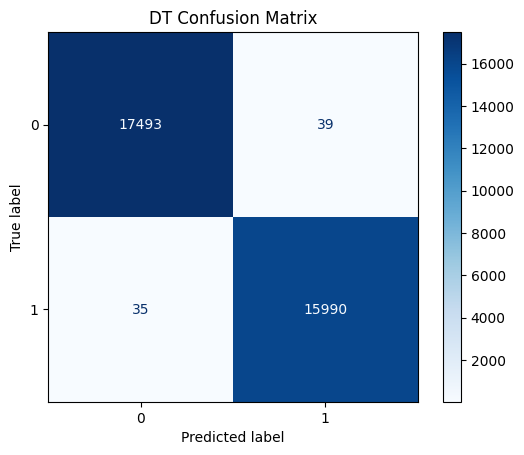

In [97]:
dt = DecisionTreeClassifier(random_state=42)

start_time = time.time()
train_metrics = compute_train_metrics(dt, X_train, y_train)
TRAINING_TIME['Decision Tree'] = time.time() - start_time

dt.fit(X_train, y_train)
test_metrics = compute_test_metrics_and_plot_cm(dt, X_test, y_test, "DT")

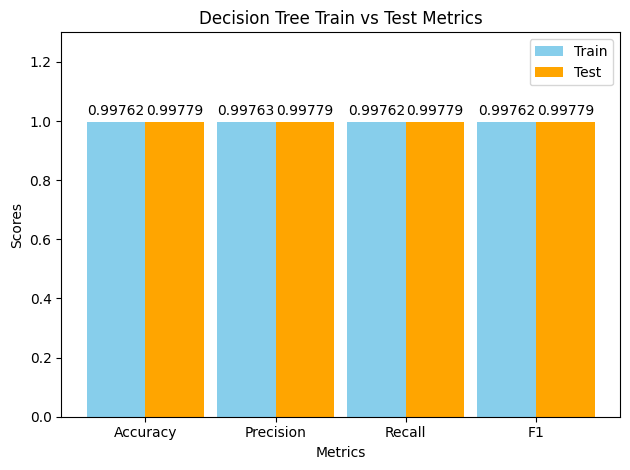

In [98]:
plot_metrics(train_metrics, test_metrics, "Decision Tree")

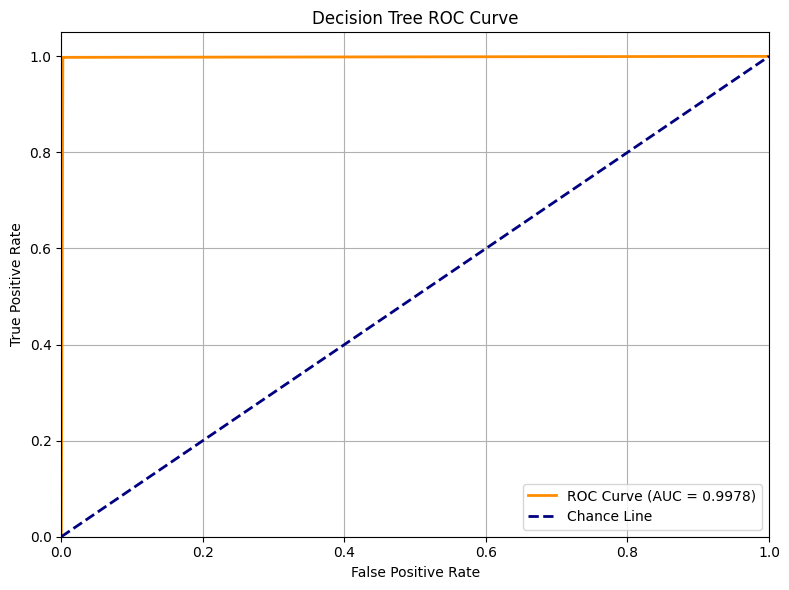

In [99]:
plot_roc_curve(dt, X_test, y_test, "Decision Tree")

# RANDOM FOREST

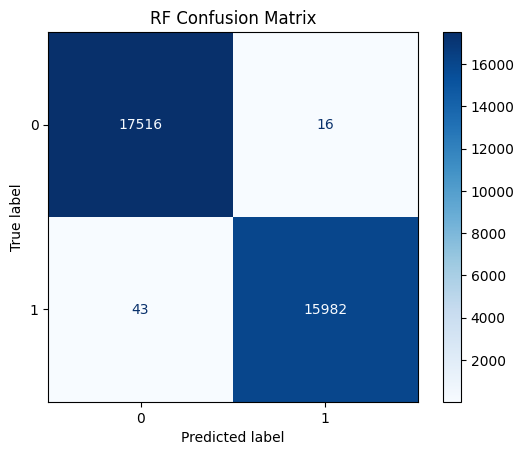

In [100]:
rf = RandomForestClassifier(random_state=42)

start_time = time.time()
train_metrics = compute_train_metrics(rf, X_train, y_train)
TRAINING_TIME['Random Forest'] = time.time() - start_time

rf.fit(X_train, y_train)
test_metrics = compute_test_metrics_and_plot_cm(rf, X_test, y_test, "RF")

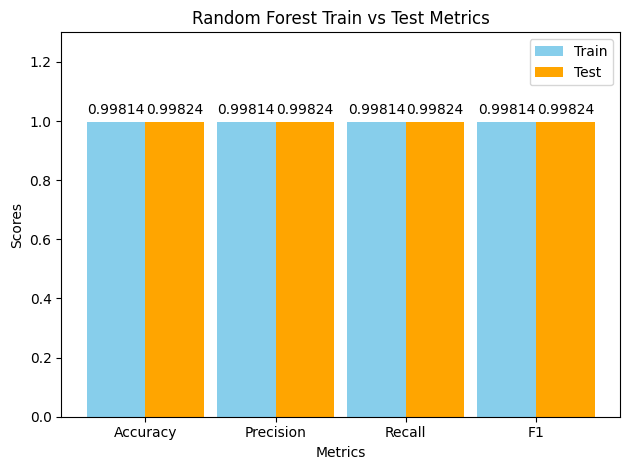

In [101]:
plot_metrics(train_metrics, test_metrics, "Random Forest")

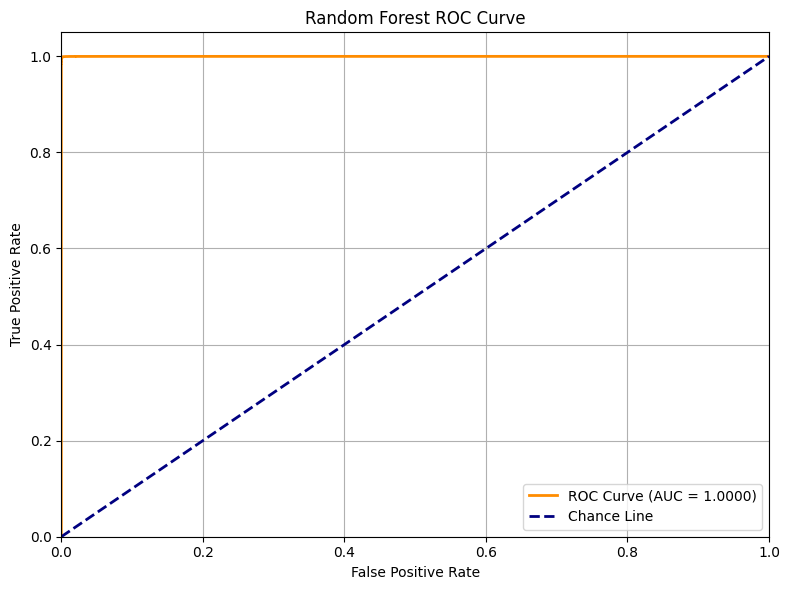

In [102]:
plot_roc_curve(rf, X_test, y_test, "Random Forest")

# GAUSSIAN NAIVE BAYES

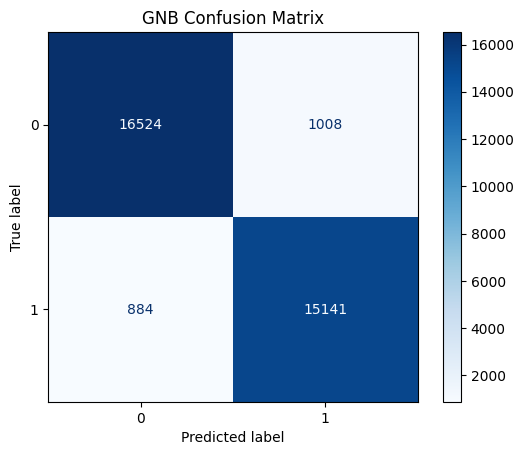

In [103]:
gnb = GaussianNB()

start_time = time.time()
train_metrics = compute_train_metrics(gnb, X_train, y_train)
TRAINING_TIME['Gaussian NB'] = time.time() - start_time

gnb.fit(X_train, y_train)
test_metrics = compute_test_metrics_and_plot_cm(gnb, X_test, y_test, "GNB")

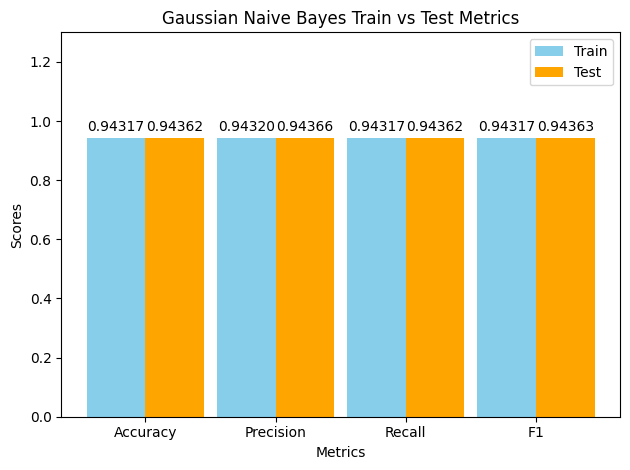

In [104]:
plot_metrics(train_metrics, test_metrics, "Gaussian Naive Bayes")

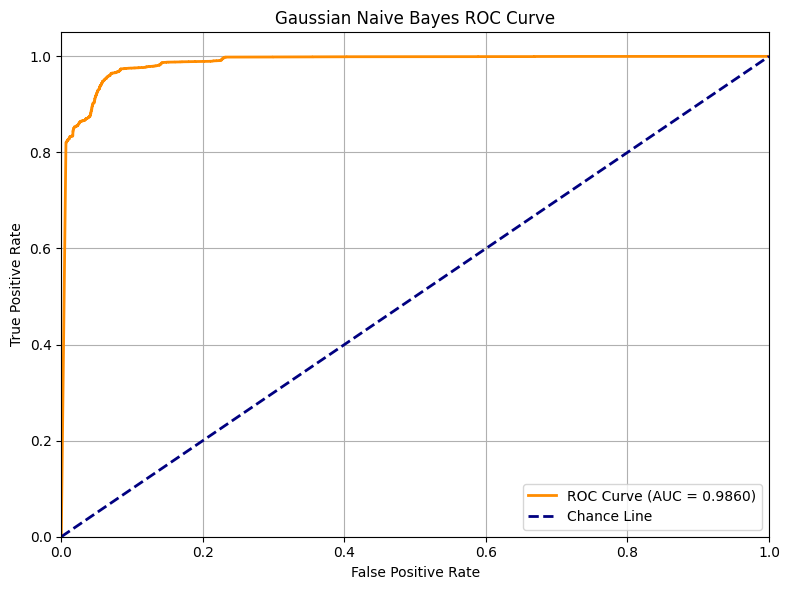

In [105]:
plot_roc_curve(gnb, X_test, y_test, "Gaussian Naive Bayes")

# SUPPORT VECTOR MACHINE

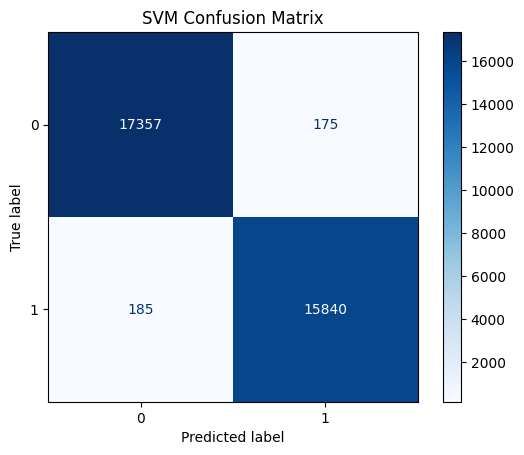

In [106]:
svm = SVC(random_state=42)

start_time = time.time()
train_metrics = compute_train_metrics(svm, X_train, y_train)
TRAINING_TIME['SVM'] = time.time() - start_time

svm.fit(X_train, y_train)
test_metrics = compute_test_metrics_and_plot_cm(svm, X_test, y_test, "SVM")

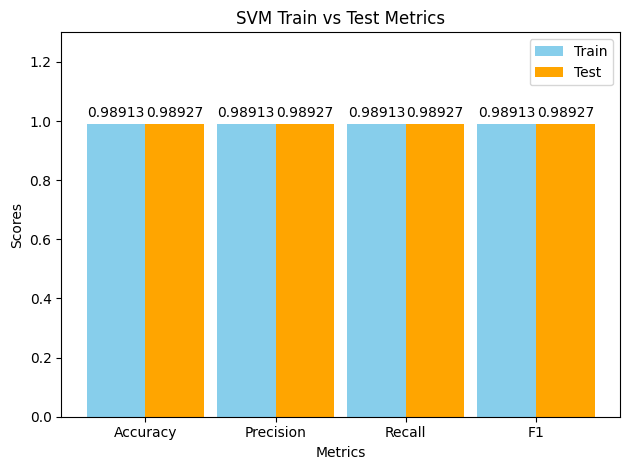

In [107]:
plot_metrics(train_metrics, test_metrics, "SVM")

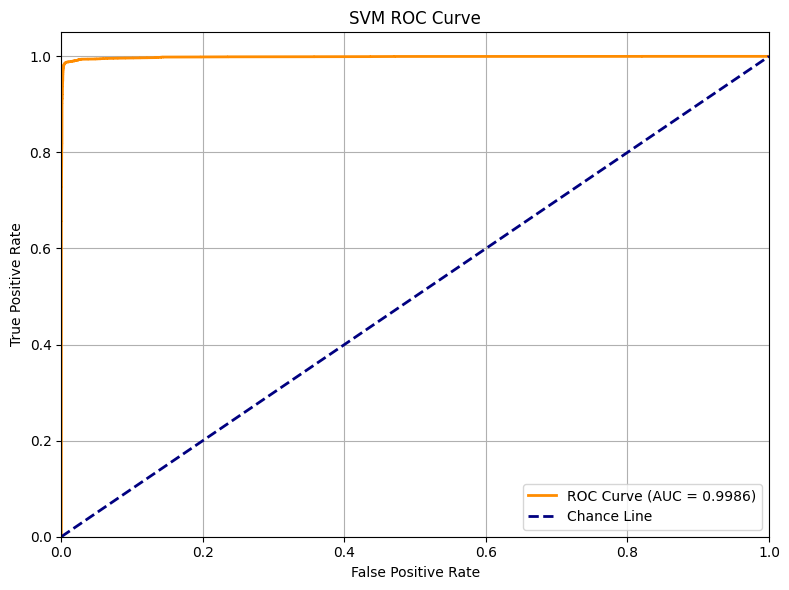

In [108]:
plot_roc_curve(svm, X_test, y_test, "SVM")

# GRADIENT BOOSTING CLASSIFIER

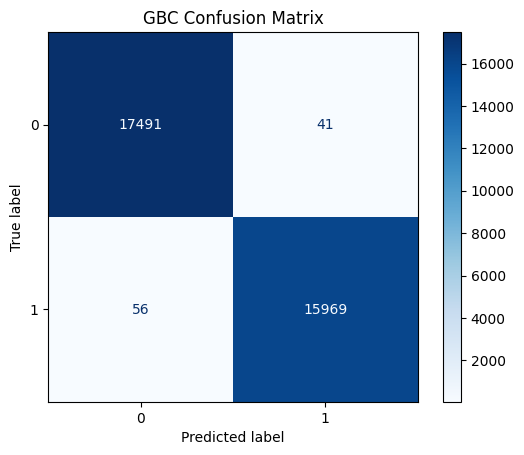

In [109]:
gbc = GradientBoostingClassifier(random_state=42)

start_time = time.time()
train_metrics = compute_train_metrics(gbc, X_train, y_train)
TRAINING_TIME['Gradient Boosting Classifier'] = time.time() - start_time

gbc.fit(X_train, y_train)
test_metrics = compute_test_metrics_and_plot_cm(gbc, X_test, y_test, "GBC")

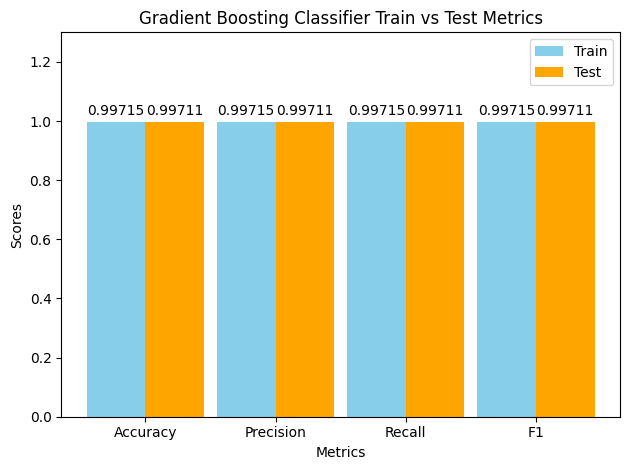

In [110]:
plot_metrics(train_metrics, test_metrics, "Gradient Boosting Classifier")

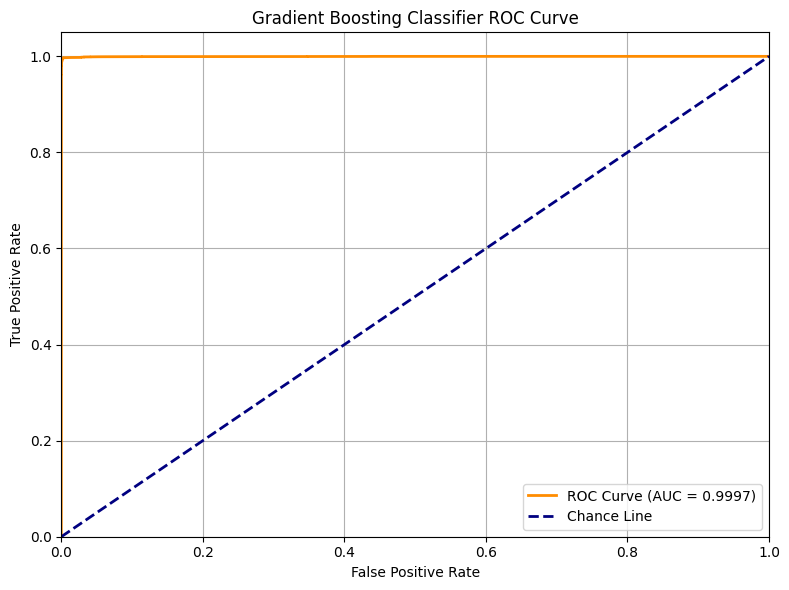

In [111]:
plot_roc_curve(gbc, X_test, y_test, "Gradient Boosting Classifier")

# TRAINING TIME COMPARISON

In [112]:
from tabulate import tabulate
table_data = [[model, f"{time:.2f} seconds"] for model, time in TRAINING_TIME.items()]
headers = ["Model", "Training Time"]
print(tabulate(table_data, headers=headers, tablefmt="grid"))

+------------------------------+-----------------+
| Model                        | Training Time   |
+==============================+=================+
| Logistic Regression          | 2.36 seconds    |
+------------------------------+-----------------+
| Decision Tree                | 1.01 seconds    |
+------------------------------+-----------------+
| Random Forest                | 18.12 seconds   |
+------------------------------+-----------------+
| Gaussian NB                  | 0.55 seconds    |
+------------------------------+-----------------+
| SVM                          | 115.63 seconds  |
+------------------------------+-----------------+
| Gradient Boosting Classifier | 53.84 seconds   |
+------------------------------+-----------------+


# VISUALIZATION OF TRAINING TIME FOR BETTER INSIGHTS

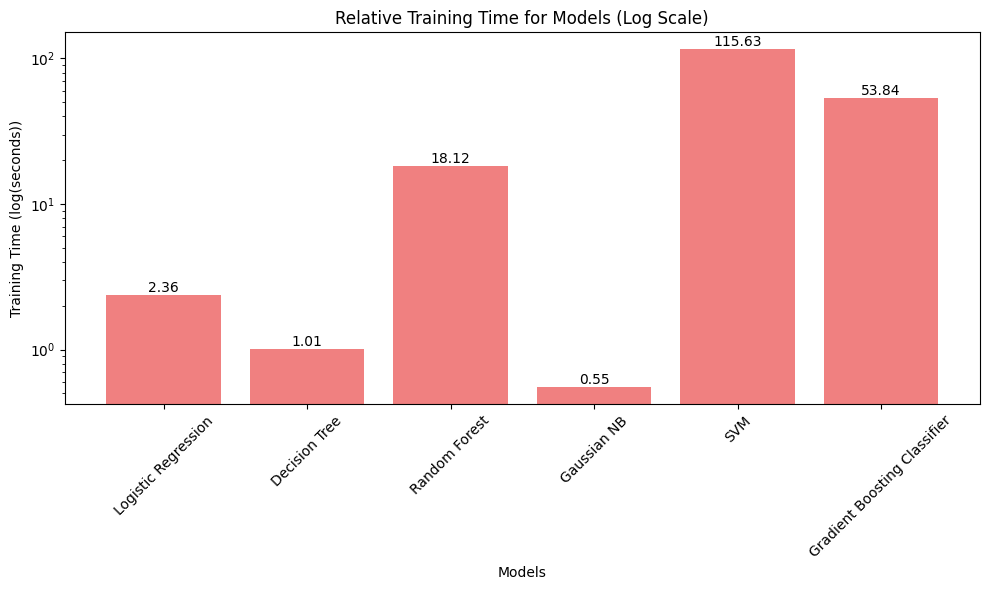

In [113]:
plt.figure(figsize=(10, 6))
plt.bar(TRAINING_TIME.keys(), TRAINING_TIME.values(), color='lightcoral', log=True)

for i, (model, time) in enumerate(TRAINING_TIME.items()):
    plt.text(i, time, f"{time:.2f}", ha='center', va='bottom', fontsize=10)

plt.xlabel("Models")
plt.ylabel("Training Time (log(seconds))")
plt.title("Relative Training Time for Models (Log Scale)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()